In [14]:
from collections.abc import Sequence
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.models import (
    Orientation,
    Resolution,
)
from histalign.backend.models.errors import InvalidOrientationError

vedo.settings.default_backend = "vtk"

In [15]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def show(meshes: vedo.CommonVisual | list[vedo.CommonVisual]) -> None:
    plotter = vedo.Plotter(axes=4)

    if not isinstance(meshes, list):
        meshes = [meshes]

    for mesh in meshes:
        plotter += mesh

    plotter.show(interactive=False).interactive().close()


def apply_rotation_from_raw(
    vector: np.ndarray, pitch: int, yaw: int, orientation: Orientation
) -> np.ndarray:
    match orientation:
        case Orientation.CORONAL:
            rotation = Rotation.from_euler("ZY", [pitch, yaw], degrees=True)
        case Orientation.HORIZONTAL:
            rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
        case Orientation.SAGITTAL:
            rotation = Rotation.from_euler("XY", [pitch, yaw], degrees=True)
        case other:
            raise InvalidOrientationError(other)

    return rotation.apply(vector)


def compute_normal_from_raw(
    pitch: int, yaw: int, orientation: Orientation
) -> np.ndarray:
    match orientation:
        case Orientation.CORONAL:
            normal = [1, 0, 0]
        case Orientation.HORIZONTAL:
            normal = [0, 1, 0]
        case Orientation.SAGITTAL:
            normal = [0, 0, 1]
        case other:
            raise InvalidOrientationError(other)

    return apply_rotation_from_raw(np.array(normal), pitch, yaw, orientation).reshape(3)


def compute_centre(shape: Sequence[int]) -> tuple[int, ...]:
    return tuple((np.array(shape) - 1) // 2)


def compute_origin_from_raw(
    centre: Sequence[int], offset: int, orientation: Orientation
) -> np.ndarray:
    if len(centre) != 3:
        raise ValueError(f"Centre should be 3 coordinates. Got {len(centre)}.")

    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise InvalidOrientationError(other)

    return np.array(origin)


def magnitude(v):
    return np.sqrt(np.sum(np.array(v) ** 2))


def project_vectors(target, vectors):
    projections = []
    for vector in vectors:
        magnitude_ = magnitude(vector)
        angle = vector_angle(vector, target)
        projections.append(magnitude_ * math.cos(angle))

    return projections


def vector_angle(v1, v2):
    return math.degrees(math.acos(np.dot(v1, v2) / (magnitude(v1) * magnitude(v2))))


def cut_with_plane(plane, origin, normal, height: bool):
    shape = plane.metadata["shape"]

    plane.cut_with_plane(origin=origin, normal=normal, invert=True)

    after = len(plane.points)
    if height:
        after /= shape[1]
    else:
        after /= shape[0]

    if height:
        shape[0] = after
    else:
        shape[1] = after

    print(f"Updating shape to: {shape}")
    plane.metadata["shape"] = shape

In [3]:
volume = load_volume(get_atlas_path(Resolution.MICRONS_100))

orientation = Orientation.CORONAL
offset = 0
pitch = 0
yaw = 0

origin = compute_origin_from_raw(
    compute_centre(volume.tonumpy().shape), offset, orientation
)
normal = compute_normal_from_raw(pitch, yaw, orientation).tolist()

In [4]:
crop_plane = volume.slice_plane(origin=origin, normal=normal, autocrop=True)

crop_plane_array = crop_plane.pointdata["ImageScalars"].reshape(
    crop_plane.metadata["shape"]
)

crop_plane_array = rotate(crop_plane_array, pitch, reshape=False)

In [5]:
no_crop_plane = volume.slice_plane(origin=origin, normal=normal, autocrop=False)

no_crop_plane_array = no_crop_plane.pointdata["ImageScalars"].reshape(
    no_crop_plane.metadata["shape"]
)

no_crop_plane_array = rotate(no_crop_plane_array, pitch, reshape=False)

In [6]:
plane = vedo.Plane(
    pos=origin,
    normal=compute_normal_from_raw(0, 0, orientation),
    s=(max(volume.tonumpy().shape),) * 2,
)

plane.rotate(pitch, axis=[0, 0, 1], point=origin)
plane.rotate(
    yaw,
    axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
    point=origin,
)
plane.rotate(
    -pitch,
    axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
    point=origin,
);

In [7]:
normal1 = plane.points[0] - plane.points[1]
normal2 = plane.points[1] - plane.points[3]
normal3 = plane.points[3] - plane.points[2]
normal4 = plane.points[2] - plane.points[0]

In [8]:
new_plane = no_crop_plane.copy()

cut_with_plane(new_plane, origin + normal1 * 0.5, normal1, height=False)
cut_with_plane(new_plane, origin + normal2 * 0.5, normal2, height=True)
cut_with_plane(new_plane, origin + normal3 * 0.5, normal3, height=False)
cut_with_plane(new_plane, origin + normal4 * 0.5, normal4, height=True)

new_plane_array = new_plane.pointdata["ImageScalars"].reshape(
    new_plane.metadata["shape"]
)

new_plane_array = rotate(new_plane_array, pitch, reshape=False)

[123 130]
[123 130]
[123 130]
[119 130]


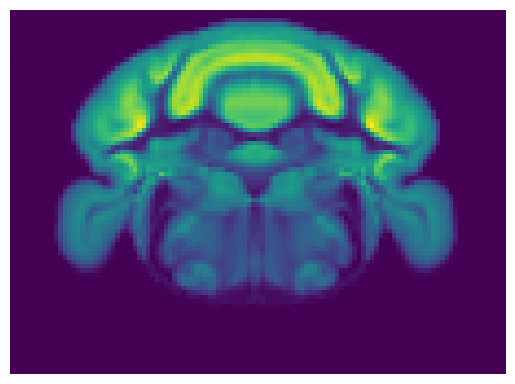

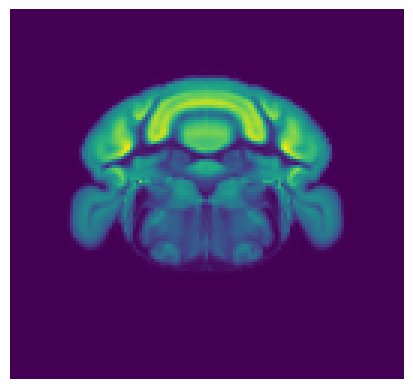

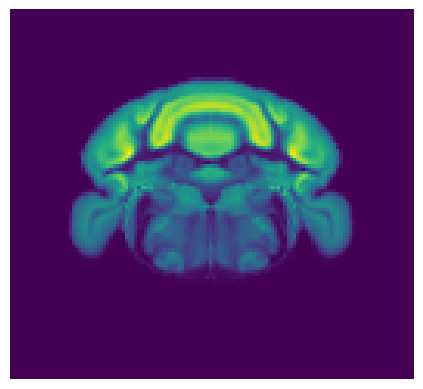

In [11]:
imshow(crop_plane_array)
imshow(no_crop_plane_array)
imshow(new_plane_array)